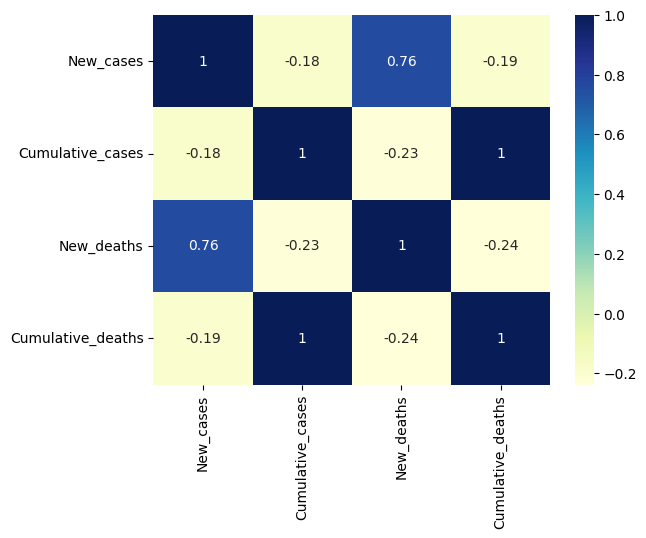

In [4]:
# Import packages
import plotly.express as px
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
# Read in the data
data= pd.read_csv(r'C:\Users\HP\Downloads\WHO_India.csv',parse_dates=True)
len(data)
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", annot=True)
  


# displaying heatmap
plt.show()


In [5]:
data = data.drop('Country_code',axis='columns')
data = data.drop('Country',axis='columns')
data= data.drop('WHO_region',axis='columns')
data= data.drop('Cumulative_cases',axis='columns')
data = data.drop('New_deaths',axis='columns')
data= data.drop('Cumulative_deaths',axis='columns')
data['Date_reported'] = pd.to_datetime(data['Date_reported'])
data.columns[data.isna().any()]
len(data)

C:\Users\HP\AppData\Local\Temp\ipykernel_14120\386439686.py:7: UserWarning:

Parsing '13-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\HP\AppData\Local\Temp\ipykernel_14120\386439686.py:7: UserWarning:

Parsing '14-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\HP\AppData\Local\Temp\ipykernel_14120\386439686.py:7: UserWarning:

Parsing '15-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\HP\AppData\Local\Temp\ipykernel_14120\386439686.py:7: UserWarning:

Parsing '16-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\HP\AppData\Local\Temp\ipykernel_14120\386439686.py:7: UserWarning:

Parsing '17-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\H

1226

In [6]:
def plot_passenger_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the passenger data."""

    fig = px.line(df, x='Date_reported', y=y, labels={'Date': 'New_cases'})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Confirmed_Cases',
                      width=650, title_x=0.5, height=400)

    return fig.show()


# Plot the airline passenger data
plot_passenger_volumes(df=data, y='New_cases')
# Import packages
from scipy.stats import boxcox

# Make the target stationary
data['New_cases_boxcox'], lam = boxcox(data['New_cases'])
data["New_cases_stationary"] = data["New_cases_boxcox"].diff()
#data["New_cases_stationary"] =data["New_cases_boxcox"].diff().diff()
data.dropna(inplace=True)

# Plot the stationary airline passenger data
plot_passenger_volumes(df=data, y='New_cases_stationary')

In [7]:
# Import packages
from statsmodels.tsa.stattools import adfuller

# ADF test for stationary
def adf_test(data):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for threshold, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (threshold, adf_stat))


print(adf_test(data["New_cases_stationary"]))


ADF Statistic:  -5.11559788999922
P-Value:  1.3041119561436363e-05
Critical Values:
	1%: -3.44
	5%: -2.86
	10%: -2.57
None


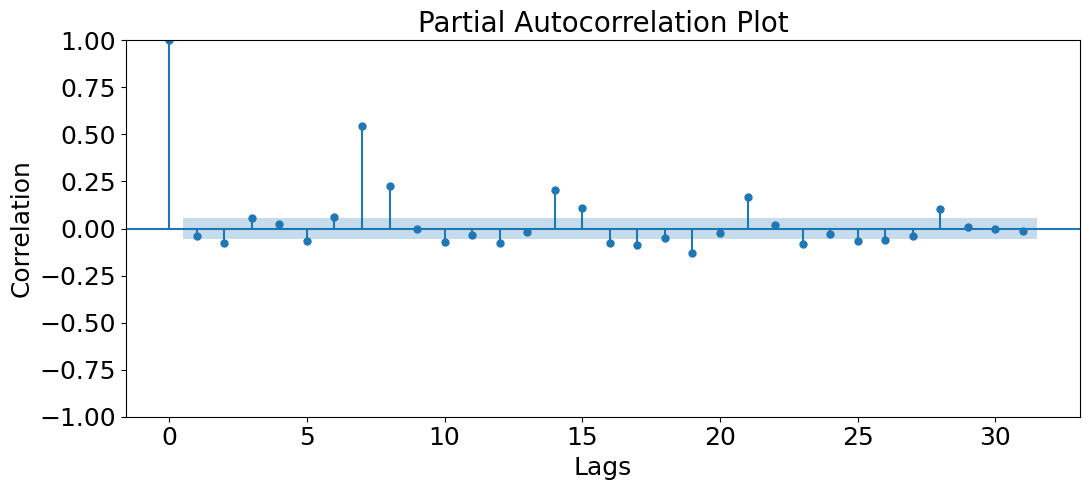

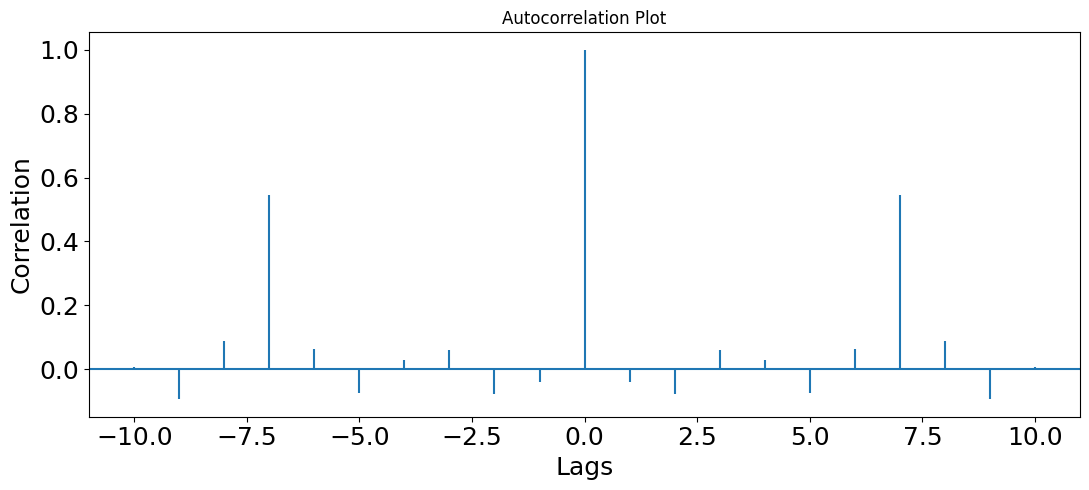

In [8]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Plot partial autocorrelation
plt.rc("figure", figsize=(11,5))
plot_pacf(data['New_cases_stationary'], method='ywm')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Partial Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

plt.acorr(data['New_cases_stationary'], maxlags = 10)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot')
plt.tight_layout()

In [9]:
# Import packages
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Split train and test
train_size = int(len(data))
train, test = data[0:613], data[613:]

# Build AR model
selector = ar_select_order(train['New_cases_stationary'], 15)
model = AutoReg(train['New_cases_stationary'], lags=selector.ar_lags).fit()

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [10]:
# Import packages
from scipy.special import inv_boxcox
import plotly.graph_objects as go

# Get forecasts and convert to actual passenger volumes
transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['New_cases_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)


def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    #fig.add_trace(go.Scatter(x=train['Date_reported'], y=train['New_cases'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Date_reported'], y=test['New_cases'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Date_reported'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='New_cases_Cases Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Autoregression')

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test['New_cases'], forecasts))

In [12]:
max(forecasts)

22832.701252942938

In [13]:
import numpy as np
def smape(act,forc):
    return 100/len(act) * np.sum(2 * np.abs(forc - act) / (np.abs(act) + np.abs(forc)))
result = smape(test['New_cases'], forecasts)
print(result)

128.7707800165284


In [14]:
m1=max(test['New_cases'])
m2=min(test['New_cases'])
diff=m1-m2
nrmse=rmse/diff
print(nrmse)

0.15383894846573323


In [15]:
#losscal=[]
#for i in range(0,len(test['New_cases'])):
 #   losscal[i]=test['New_cases'][i]-forecasts[i]
losscal=test['New_cases']-forecasts

In [16]:
import matplotlib.pyplot as plt


In [17]:
def mean_absolute_error(true, pred):
    abs_error = ((np.abs(true - pred))**2)/30
    return abs_error
abs=mean_absolute_error(test['New_cases'],forecasts)
abs

614     2.866942e+04
615     7.748802e+04
616     2.887007e+04
617     6.457700e+03
618     3.229528e+04
            ...     
1221    1.709585e+07
1222    1.713804e+07
1223    1.721217e+07
1224    1.727587e+07
1225    1.737622e+07
Name: New_cases, Length: 612, dtype: float64

Text(0.5, 0, 'Date')

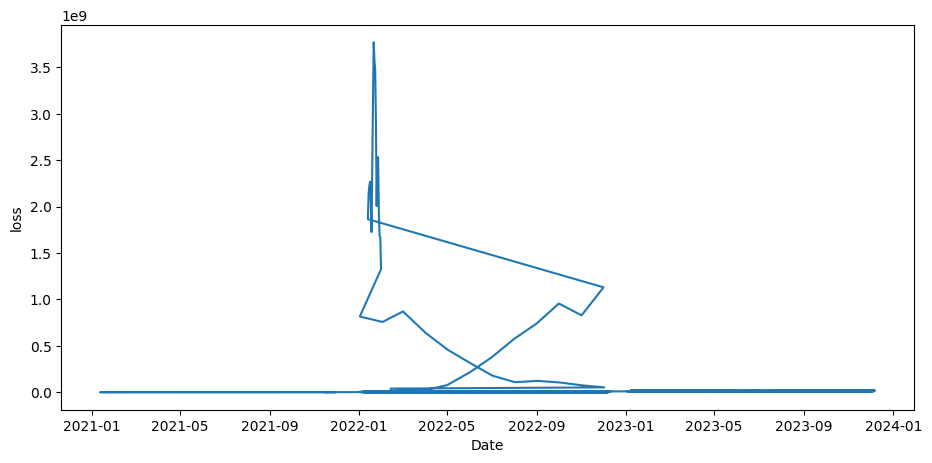

In [18]:
plt.plot(test['Date_reported'],abs)
plt.ylabel('loss')
plt.xlabel('Date')

In [19]:
from datetime import datetime
datacolumns=["Date_reported","New_cases"]

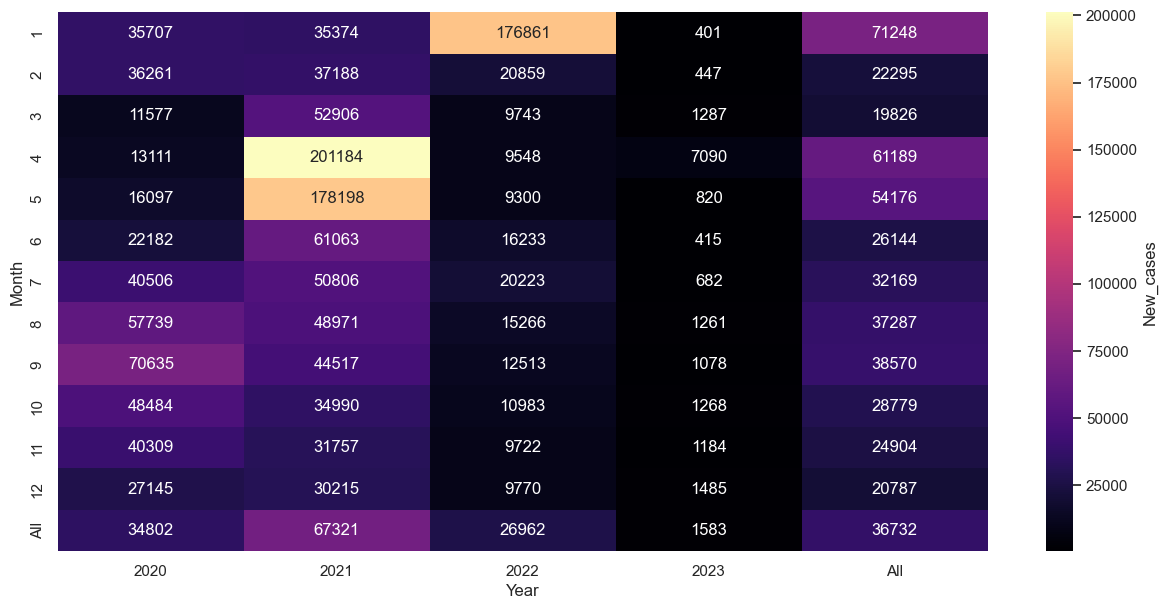

In [20]:
import seaborn as sns
data['Year'] = data['Date_reported'].dt.year


data['Month'] = data['Date_reported'].dt.month
 
pivot_table = pd.pivot_table(data, values=["New_cases"],
                             index=["Month"], columns=["Year"],
                             margins=True)

pivot_table.columns = pivot_table.columns.droplevel() 

sns.set(rc={'figure.figsize': (15, 7)})
ax = sns.heatmap(pivot_table, cmap='magma', fmt='.0f', annot=True, 
                 cbar_kws={'label':'New_cases'})
